<h2> <center><strong>Ecole Polytechnique de Tunisie</strong> </center> </h2> 
<center> <img src="https://nhoues.github.io/Infrastructure-Project/Animations/EPT.jpg" style="width:5px; height:5px"  ></center>

<h1><center>Mini projet conception des systèmes d'information</center></h1>
<h1><em><center>Problème de détection de fraud STEG</em></center></h1>
<h3><center><em>Réalisé par :</em> <font color='blue'> Naim Houes & Malek Mechergui</font></center></h3> 


# Introduction 

Our best-performing methods for modeling sequence data use deep neural networks, usually either modified recurrent neural networks (RNNs) or attention-based Transformer blocks.  
in this notebook we will try to use the RNN's and the attention-based Transforemr to detect the electricty frauder 

# Importaions 

In [0]:
!pip install transformers 
!pip install torchcontrib

In [0]:
import os 
from functools import partial

import pandas as pd
from pandas import DataFrame
from pandas import concat
import copy , math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time, gc 
import torch 
from torch import nn,optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing  
import transformers 
from tqdm.notebook import tqdm
from torchcontrib.optim import SWA
import torchcontrib

import random

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
tqdm.pandas()

from collections import defaultdict

from torch.utils.data.distributed import DistributedSampler
from typing import Iterator, List, Optional
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Dataset
from operator import itemgetter

%matplotlib inline


In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load the data 

In [0]:
train =pd.read_csv('/content/drive/My Drive/min projet/DL_train_client.csv')
test = pd.read_csv('/content/drive/My Drive/min projet/DL_test_client.csv')

In [0]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['Fraud'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Fraud')
ax[0].set_ylabel('')
sns.countplot('Fraud',data=train,ax=ax[1])
ax[1].set_title('Fraud')
plt.show()

In [0]:
train['seq_len'].hist()

In [0]:
train['seq_len_input'] = train['seq_len']
test['seq_len_input'] = test['seq_len']

# Data preporecessing 

In [0]:
fix_columns = [  'district' , 'client_catg' , 'region' ,'counter_coefficient'	,'Tarif'	,	'seq_len_input']
num_colmuns = ['max_consumption','min_consumption','std_consumption','mean_consumption']
target =  'Fraud'

In [0]:
all_data = pd.concat([train,test])
for f in fix_columns : 
  label_encoder = preprocessing.LabelEncoder()
  label_encoder.fit(all_data[f].astype('str'))
  train[f] = label_encoder.transform(train[f].astype('str').fillna('-1'))
  test[f] = label_encoder.transform(test[f].astype('str').fillna('-1'))

In [0]:
for f in num_colmuns : 
  scale = preprocessing.MinMaxScaler()
  scale.fit(train[f].values.reshape(-1,1))
  train[f] = scale.transform(train[f].values.reshape(-1,1))
  test[f] = scale.transform(test[f].values.reshape(-1,1))

# Entity Embedding dim 

since we have decided to use embeddings layers to encode the categorical features in this section we will create a function that returns a list that maps each categorical feature to there embedding dimension.  

Entity Embeddings paper : https://arxiv.org/abs/1604.06737

In [0]:
def get_emb_dim(df,categorical):
    output=[]
    for categorical_var in categorical:

      cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'

      no_of_unique_cat  = df[categorical_var].nunique()
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 32))
      output.append((no_of_unique_cat,embedding_size))    
      print('Categorica Variable:', categorical_var,
          'Unique Categories:', no_of_unique_cat,
          'Embedding Size:', embedding_size)
  
      
    return output

In [0]:
entity_dim = get_emb_dim(train ,fix_columns)

# Dataset class 

we have created a dataset class for our Steg client dataset. We will read the data in __init__ but leave the reading of the rows  to __getitem__. This is memory efficient because all the dataset rows are not stored in the GPU memory at once but read as required.


In [0]:
seq_cat = dict()
seq_num = dict()
for f in ['consumption_per_month','mean_lag','max_lag','min_lag','std_lag','var_lag'] : 
  seq_num[f] = consumption_columns = [f"('{f}', 'seq(t= {i})')" for i in range(train['seq_len'].max())]
for f in ['level','quarter'] : 
  seq_cat[f] = consumption_columns = [f"('{f}', 'seq(t= {i})')" for i in range(train['seq_len'].max())]

In [0]:
class steg_data_set() : 
  def __init__(self,df) : 
    
    self.df = df 
    
    out = dict()
    out['num'] = df[num_colmuns].values   

    for f in fix_columns  : 
      out[f] = df[f].values 

    for f in seq_num.keys() : 
       out[f] = df[seq_num[f]].values 
    
    for f in seq_cat.keys() : 
       out[f] = df[seq_cat[f]].values 
    out['Fraud'] = df['Fraud'].values

    out['seq_len'] = df['seq_len'].values
    
    
    self.df = out



  def __len__(self) : 
    return(len(self.df['Fraud']))
  def __getitem__(self,item) : 
    out = dict()

    for i in  fix_columns: 
        out[i] = torch.tensor( self.df[i][item] , dtype=torch.long )

    for f in seq_num.keys() : 
       out[f] = torch.tensor(self.df[f][item] , dtype= torch.float ) 
    
    for f in seq_cat.keys() : 
       out[f] =torch.tensor(self.df[f][item] , dtype = torch.long ) 

    out['seq_len'] =torch.tensor(self.df['seq_len'][item] , dtype = torch.long)
    out['num'] = torch.tensor(self.df['num'][item] , dtype = torch.float)
    out['Fraud'] =torch.tensor(self.df['Fraud'][item] , dtype = torch.long)
    out['mask'] = torch.tensor((self.df['consumption_per_month'][item] != 0),dtype=torch.float).unsqueeze(-2)
    return out
  def get_labels(self):
        return list(self.df['Fraud'])


## Class Balance with PyTorch 

In [0]:
##################################
## parts of code from catalyst: ##
##################################

class DatasetFromSampler(Dataset):
    """Dataset of indexes from `Sampler`."""

    def __init__(self, sampler: Sampler):
        """
        Args:
            sampler (Sampler): @TODO: Docs. Contribution is welcome
        """
        self.sampler = sampler
        self.sampler_list = None

    def __getitem__(self, index: int):
        """Gets element of the dataset.
        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        if self.sampler_list is None:
            self.sampler_list = list(self.sampler)
        return self.sampler_list[index]

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.sampler)


class DistributedSamplerWrapper(DistributedSampler):
    """
    Wrapper over `Sampler` for distributed training.
    Allows you to use any sampler in distributed mode.
    It is especially useful in conjunction with
    :class:`torch.nn.parallel.DistributedDataParallel`. In such case, each
    process can pass a DistributedSamplerWrapper instance as a DataLoader
    sampler, and load a subset of subsampled data of the original dataset
    that is exclusive to it.
    .. note::
        Sampler is assumed to be of constant size.
    """

    def __init__(
        self,
        sampler,
        num_replicas: Optional[int] = None,
        rank: Optional[int] = None,
        shuffle: bool = True,
    ):
        """
        Args:
            sampler: Sampler used for subsampling
            num_replicas (int, optional): Number of processes participating in
                distributed training
            rank (int, optional): Rank of the current process
                within ``num_replicas``
            shuffle (bool, optional): If true (default),
                sampler will shuffle the indices
        """
        super(DistributedSamplerWrapper, self).__init__(
            DatasetFromSampler(sampler),
            num_replicas=num_replicas,
            rank=rank,
            shuffle=shuffle,
        )
        self.sampler = sampler

    def __iter__(self):
        """@TODO: Docs. Contribution is welcome."""
        self.dataset = DatasetFromSampler(self.sampler)
        indexes_of_indexes = super().__iter__()
        subsampler_indexes = self.dataset
        return iter(itemgetter(*indexes_of_indexes)(subsampler_indexes))

class BalanceClassSampler(Sampler):
    """Abstraction over data sampler.
    Allows you to create stratified sample on unbalanced classes.
    """

    def __init__(self, labels: List[int], mode: str = "downsampling"):
        """
        Args:
            labels (List[int]): list of class label
                for each elem in the datasety
            mode (str): Strategy to balance classes.
                Must be one of [downsampling, upsampling]
        """
        super().__init__(labels)

        labels = np.array(labels)
        samples_per_class = {
            label: (labels == label).sum() for label in set(labels)
        }

        self.lbl2idx = {
            label: np.arange(len(labels))[labels == label].tolist()
            for label in set(labels)
        }

        if isinstance(mode, str):
            assert mode in ["downsampling", "upsampling"]

        if isinstance(mode, int) or mode == "upsampling":
            samples_per_class = (
                mode
                if isinstance(mode, int)
                else max(samples_per_class.values())
            )
        else:
            samples_per_class = min(samples_per_class.values())

        self.labels = labels
        self.samples_per_class = samples_per_class
        self.length = self.samples_per_class * len(set(labels))

    def __iter__(self) -> Iterator[int]:
        """
        Yields:
            indices of stratified sample
        """
        indices = []
        for key in sorted(self.lbl2idx):
            replace_ = self.samples_per_class > len(self.lbl2idx[key])
            indices += np.random.choice(
                self.lbl2idx[key], self.samples_per_class, replace=replace_
            ).tolist()
        assert len(indices) == self.length
        np.random.shuffle(indices)

        return iter(indices)

    def __len__(self) -> int:
        """
        Returns:
             length of result sample
        """
        return self.length

in this section we have defined a pytorch sampler from **Catalyst Team** for our loaders for retrieve balanced dataset in the streaming , also for the training distribution. 

**Demonstartion for this technique** 

In [0]:
train_dataset = steg_data_set(train)

Usually loader:

In [0]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    pin_memory=False,
    drop_last=False,
    num_workers=2
)

In [0]:
result = {'Fraud': []}
for labels in tqdm(train_loader, total=len(train_loader)):
    result['Fraud'].extend(labels['Fraud'].numpy())

pd.DataFrame(result)['Fraud'].hist()
plt.title('Training class distribution')
plt.show()

Using balance  sampler (Downsampling mode) :

In [0]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode='downsampling'),  # here 2 modes: downsampling/upsampling
    pin_memory=False,
    drop_last=False,
    num_workers=2
)

In [0]:
result = {'Fraud': []}
for labels in tqdm(train_loader, total=len(train_loader)):

    result['Fraud'].extend(labels['Fraud'].numpy())
    
pd.DataFrame(result)['Fraud'].hist()
plt.title('Training class distribution')
plt.show()

# Lstm based Model 

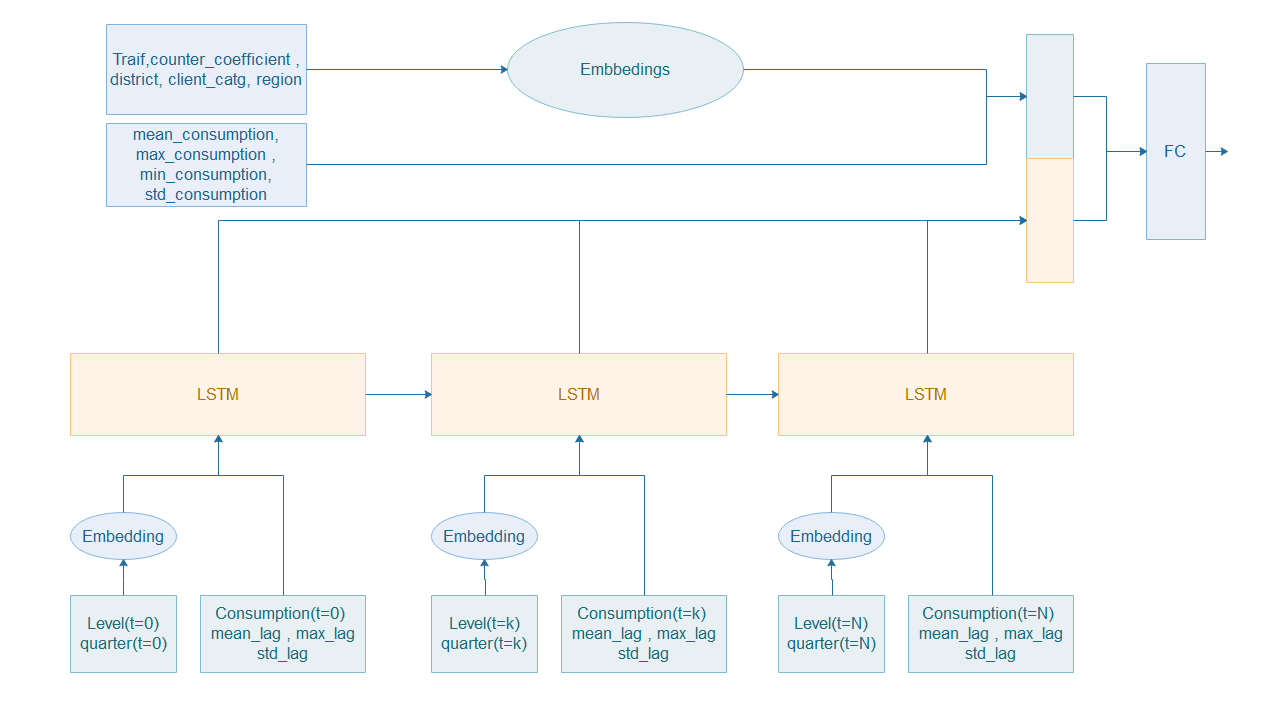

we have tow parts in our model : 
* **Sequence Encoder :** we have used a Lstm ( Long short term memory ) block to encode the information from the sequence of consumption history.    

* **Fully connected layer :**  we concated the output of the encoder block with the information of the counter . 



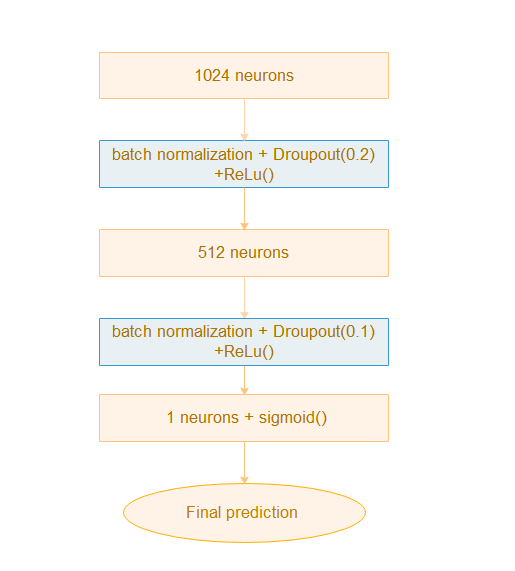

### Implementation  

In [0]:
class Encoder(nn.Module):
  
  def __init__(self,enc_hid_dim, output_dim, dropout):
   
    super(Encoder,self).__init__()
    self.output_dim = output_dim
    self.embedding_level = nn.Embedding(5, 2)
    self.embedding_quarter = nn.Embedding(5, 2)
    
    self.rnn = nn.LSTM( 4 + 6 , enc_hid_dim)
    self.fc = nn.Linear(enc_hid_dim , output_dim)
    self.dropout = nn.Dropout(dropout)
  def attention_net(self, lstm_output, final_state):
    
    hidden = final_state.squeeze(0)
    attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
    soft_attn_weights = F.softmax(attn_weights, 1)
    new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
		
    return new_hidden_state
      
  def forward(self,data):
    x_cat = []
    x = data['level'].to(device,dtype=torch.long) 
    x = x.permute(1,0)
    x =  self.embedding_level(x) 
    x_cat.append(x)




    x = data['quarter'].to(device,dtype=torch.long) 
    x = x.permute(1,0)
    x =  self.embedding_quarter(x) 
    x_cat.append(x)

    x_cat = torch.cat(x_cat,axis=2)


    x_num = []
    for f in seq_num.keys() :
      x = data[f].to(device,dtype=torch.float) 
      x = x.permute(1,0)
      x = x.unsqueeze(2)
      x_num.append(x)
    x_num = torch.cat(x_num, axis = 2 )

    embedded = torch.cat( [ x_num , x_cat ] ,axis = 2 )
   
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,  data['seq_len'],enforce_sorted=False)
    output, (final_hidden_state, final_cell_state) = self.rnn(packed_embedded) 
    outputs, _ = nn.utils.rnn.pad_packed_sequence(output)
    outputs = outputs.permute(1, 0, 2) 

    attn_output  =  self.attention_net(outputs, final_hidden_state)
    final_output =  self.fc(attn_output)

    return final_output

In [0]:
class steg_GRU_model(nn.Module) : 
  
  def __init__(self, encoder , emb_size) : 
    
    super(steg_GRU_model,self).__init__() 
    self.Encoder = encoder 
    self.enc_dim = encoder.output_dim

    outputs_cat = nn.ModuleList() # define the Embedding layer
    for inp , emb  in emb_size :
        embedding_layer = nn.Embedding(inp+2,emb)
        outputs_cat.append(embedding_layer)
    self.outputs_cat = outputs_cat 

    n_emb = sum([e[1] for e in emb_size])


    self.fc = nn.Sequential(  
                              nn.Linear( n_emb + self.enc_dim + len(num_colmuns)  ,1024),
                       
                              nn.BatchNorm1d(1024),
                              nn.Dropout(0.2),
                              nn.ReLU(),
                              nn.Linear( 1024 ,512),
                              nn.BatchNorm1d(512),
                              nn.Dropout(0.1),
                              nn.ReLU(),
                              nn.Linear(512,1),
                              
    )
    
  def forward(self,data) : 
   
      enc_output = self.Encoder(data)
      
      
      
      
      outputs_emb = [] 
      for i in range(len(fix_columns)) : 
          inputs = data[fix_columns[i]].to(device,dtype=torch.long) 
          out = self.outputs_cat[i](inputs)
          outputs_emb.append(out.squeeze(1)) 
      x_cat = torch.cat(outputs_emb,dim= 1)
      x_num =  data["num"].to(device,dtype=torch.float) 
      x_all = torch.cat([x_cat,enc_output,x_num],dim=1)

      x_out =torch.sigmoid( self.fc(x_all)).to(device,dtype=torch.float) 
      return x_out

# Engine 

In [0]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))


we used a the logloss as loss function 

In [0]:
def train_fn(data_loader, model, optimizer,scheduler):
  model.train()
  
  train_losses =[]
  fin_targets = []
  fin_outputs = []

  for bi , d in tqdm(enumerate(data_loader), total=len(data_loader)):
    
    targets = d["Fraud"]
    targets = targets.to(device, dtype=torch.float)

    optimizer.zero_grad()
    
    outputs = model(d)

 
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    train_losses.append(loss.item())

    targets_np = targets.cpu().detach().numpy().tolist()
    outputs_np = outputs.cpu().detach().numpy().tolist()
    fin_targets.extend(targets_np)
    fin_outputs.extend(outputs_np)  
     
  return train_losses,fin_outputs,fin_targets

In [0]:
def eval_fn(data_loader, model):
  model.eval()
  
  valid_losses=[]
  fin_targets = []
  fin_outputs = []
  
  with torch.no_grad():
   
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      targets = d["Fraud"]
      targets = targets.to(device, dtype=torch.float)
        
      outputs = model(d)
     
      loss = loss_fn(outputs, targets)
      
      valid_losses.append(loss.item())
      
      targets_np = targets.cpu().detach().numpy().tolist()
      outputs_np = outputs.cpu().detach().numpy().tolist()
      fin_targets.extend(targets_np)
      fin_outputs.extend(outputs_np)  
    
    return valid_losses, fin_outputs ,fin_targets

In [0]:
def run(model , validation = 'train_test_split' , mode='downsampling' , Model_type = 'GRU' ,patience = 10 ):
    if str(validation) == 'train_test_split' : 
      df_train,df_valid = train_test_split(train , test_size = 0.2 , random_state = 42 )
    else : 
      print(f'----------------- Training fold {validation} ---------------------')

      df_train  = train[train['kfold'] != validation ]
      df_valid  = train[train['kfold'] == validation ]
    
    train_dataset = steg_data_set(df_train)
    valid_dataset = steg_data_set(df_valid)
    
    
    if mode == 'unbalanced' : 
      train_dataloader = DataLoader(train_dataset, NNBATCHSIZE, shuffle=True , num_workers=16)
    else : 
      train_dataloader = DataLoader(
                                  train_dataset,
                                  batch_size=NNBATCHSIZE,
                                  sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode=mode),  # here 2 modes: downsampling/upsampling
                                  pin_memory=False,
                                  drop_last=False,
                                  num_workers=2
                              )

    
    valid_dataloader = DataLoader(valid_dataset, NNBATCHSIZE, shuffle=False)

    
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(train_dataloader)) * EPOCHS
    optimizer = AdamW(optimizer_parameters, lr=LR)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )
    best_auc ,trials= 0 , 0 
    
    avg_train_losses, avg_valid_losses = [], []
    avg_train_auc , avg_valid_auc = [],[]
    
    
    model.load_state_dict(torch.load(f'/content/drive/My Drive/min projet/Models /{Model_type}_fold_{validation}_{mode}.bin'))
    df_test = steg_data_set(test)
    test_dataloader = DataLoader( df_test , NNBATCHSIZE, shuffle=False )
    test_losses , test_preds , test_true = eval_fn(test_dataloader, model)
    test_loss = np.average(test_losses)
    test_score = metrics.roc_auc_score(np.array(test_true) ,test_preds)
    print( "test_loss: {:0.6f}, test_auc: {:0.6f}".format(test_loss, test_score))
    test['Fraud_'+mode+'_'+Model_type+'_'+str(validation)] = test_preds
    def first(x) : 
      return x[0] 
    test['Fraud_'+mode+'_'+Model_type+'_'+str(validation)]= test['Fraud_'+mode+'_'+Model_type+'_'+str(validation)].apply(first)
    
    if validation == 'train_test_split' : 
      resualt = dict() 
      resualt['train_loss'] =  avg_train_losses
      resualt['valis_loss'] = avg_valid_losses
      resualt['train_auc'] = avg_train_auc
      resualt['valid_auc'] = avg_valid_auc
      return resualt

we used an AdamW optimizer and a  linear schedule with warmup for learning rate scheduling.


# Training the Lstm based model 

### Creating 5 folds for validation strategy dataset

we used StratifiedKFold from the Sklearn model_selection library to create 5 folds with the same percentage of samples for each class .

In [0]:
train["kfold"] = -1

train = train.sample(frac=1).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split( X = train, y = train.Fraud)):
    print(len(train_idx), len(val_idx))
    train.loc[val_idx, 'kfold'] = fold

In [0]:
for fold in range(5) : 
  sub = train[train['kfold']==fold]
  per_fraud= (sub[train['Fraud']==1].shape[0]/sub.shape[0])*100
  print(f'there is {per_fraud}% frauder in fold {fold}')

## utils function 

In [0]:
def plot_auc(results) : 
  # summarize history for accuracy
  plt.plot(resualts['train_auc'])
  plt.plot(resualts['valid_auc'])
  plt.title('Auc per epoch')
  plt.ylabel('Auc')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()
def conf_matrix(y_pred,y_test) : 
  fig, ax = plt.subplots(2,2,figsize=(20,20))
  conf_matrix = confusion_matrix(y_test, (y_pred>0.2).astype(int))
  sns.heatmap(conf_matrix, ax=ax[0][0], annot=True)
  ax[0, 0].set_title("Confusion Matrix \n threshold = 0.2", fontsize=14)
  ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

  conf_matrix = confusion_matrix(y_test, (y_pred>0.5).astype(int))
  sns.heatmap(conf_matrix, ax=ax[0][1], annot=True)
  ax[0][1].set_title("Confusion Matrix \n threshold = 0.5", fontsize=14)
  ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

  conf_matrix = confusion_matrix(y_test, (y_pred>0.7).astype(int))
  sns.heatmap(conf_matrix, ax=ax[1][0], annot=True)
  ax[1][0].set_title("Confusion Matrix \n threshold = 0.7", fontsize=14)
  ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

  conf_matrix = confusion_matrix(y_test, (y_pred>0.9).astype(int))
  sns.heatmap(conf_matrix, ax=ax[1][1], annot=True)
  ax[1][1].set_title("Confusion Matrix \n threshold = 0.9", fontsize=14)
  ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)
  plt.show()
  print(classification_report(y_test, (y_pred>0.5).astype(int)))


## Training with  unbalanced dataset   

In [0]:
#config 
NNBATCHSIZE = 128 
EPOCHS = 6
LR = 1e-4
device = torch.device('cpu')

In [0]:
train = train.fillna(0)
test = test.fillna(0)

In [0]:
encoder = Encoder(256,256,0.1)
model = steg_GRU_model(encoder,entity_dim)
model = model.to(device)
resualts = run(model , validation = 'train_test_split' , mode='unbalanced' , Model_type = 'GRU' ,patience = 5 )


In [0]:
conf_matrix(test['Fraud_'+'unbalanced'+'_'+'GRU'+'_'+'train_test_split'],test['Fraud'])

## Using upsampling technique 

In [0]:
NNBATCHSIZE = 128 
EPOCHS = 64
LR = 1e-4
device = torch.device('cuda')

In [0]:
encoder = Encoder(256,256,0.1)
model = steg_GRU_model(encoder,entity_dim)
model = model.to(device)
resualts = run(model , validation = 'train_test_split' , mode='upsampling' , Model_type = 'GRU' ,patience = 5 )

In [0]:
plot_auc(resualts)

In [0]:
conf_matrix(test['Fraud_'+'upsampling'+'_'+'GRU'+'_'+'train_test_split'].values,test['Fraud'].values)

In [0]:
print(classification_report(test['Fraud'].values , (test['Fraud_'+'upsampling'+'_'+'GRU'+'_'+'train_test_split'].values >0.2).astype(int)))


## Using downsampling technique

In [0]:
NNBATCHSIZE = 32 
EPOCHS = 100
LR = 1e-4
device = torch.device('cpu')

In [0]:
encoder = Encoder(256,256,0.1)
model = steg_GRU_model(encoder,entity_dim)
model = model.to(device)
resualts = run(model , validation = 'train_test_split' , mode='downsampling' , Model_type = 'GRU' ,patience = 10 )

In [0]:
conf_matrix(test['Fraud_'+'upsampling'+'_'+'GRU'+'_'+'train_test_split'].values,test['Fraud'].values)

## 5 folds downsampling : 

In [0]:
NNBATCHSIZE = 128 
EPOCHS = 60
LR = 1e-4
device = torch.device('cpu')

In [0]:
for fold in range(5) : 
  encoder = Encoder(256,256,0.1)
  model = steg_GRU_model(encoder,entity_dim)
  model = model.to(device)
  resualts = run(model , validation = fold , mode='downsampling' , Model_type = 'GRU' ,patience = 5 )

In [0]:
f = ['Fraud_downsampling_GRU_'+str(i) for i in range(5)]
test['5_folds_GRU'] = test[f].mean(axis=1)

In [0]:
conf_matrix(test['5_folds_GRU'].values,test['Fraud'].values)

In [0]:
print(classification_report(test['Fraud'].values , (test['5_folds_GRU'].values >0.2).astype(int)))


## Transformer encoder based model 

Whenever long-term dependencies  are involved, we know that RNNs (even with using hacks like bi-directional, multi-layer, memory-based gates — LSTMs/GRUs) suffer from vanishing gradient problem. Also, they handle the sequence of inputs 1 by 1 this resulting in an obstacle towards parallelization of the process. the transformer architecture solves this problem by using the attention mechanism so that why we have decided to try to implement a transformer encoder to encode the historical client consumption 
instead of the RNN's.  


* Ref : "Attention is All you Need" paper (https://arxiv.org/pdf/1706.03762.pdf) 

### The encoder Description 

this is the Transformer encoder-decoder architecture described by the "attention is all you need" paper. 

![Texte alternatif…](https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)

since our problem is a sequence to one problem we have implemented the encoder part of this architecture and we have changed the embedding input layer to be adaptative with our numerical input. then we concatenated the output of this encoder with the other computer features. 

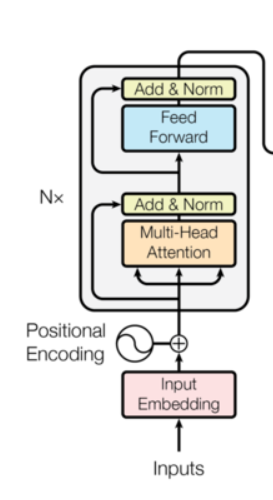

## Encoder implmentation 

The encoder is composed of a stack of N identical layers.

In [0]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [0]:
class Consupmtion_encoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, src_embed, generator):
        super(Consupmtion_encoder, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.generator = generator
        
    def forward(self, src, src_mask):
        "Take in and process masked src and target sequences."
        out = self.encode(src, src_mask)
        out = self.generator(out)
        return out
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

we employ a residual connection around each of the sub-layers, followed by layer normalization.

In [0]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $LayerNorm(x+Sublayer(x))$
, where 
$Sublayer(x)$
 is the function implemented by the sub-layer itself. We apply dropout 
to the output of each sub-layer, before it is added to the sub-layer input and normalized.

In [0]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers.The first is a multi-head self-attention mechanism , and the second is a simple, position-wise fully connected feed-forawrd network .

In [0]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

The encoder contains self-attention layers. In a self-attention layer all of the keys , values and queries come from the same place , in this case n the output of the previous layer in the encoder.

In [0]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
   # mask = mask.permute(3,1,2,0)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query , keys , values , and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key. 
$$ Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V $$

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this. 

$$ MultiHead(Q,K,V) = Concat(head_1,...head_h) W^O $$


where $ head_i= Attention(QW_i^Q,KW_i^K,VW_i^V) $

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Input Layers : 

In [0]:
class Input_Layer(nn.Module):
  def __init__(self, d_model):
    super(Input_Layer, self).__init__()
    self.embedding_level = nn.Embedding(5,3)
    self.embedding_quarter = nn.Embedding(5,3)
    self.lut = nn.Linear(12, d_model)
    self.d_model = d_model

  def forward(self, data):
   
    x_cat = []
    x = data['level'].to(device,dtype=torch.long) 
    x =  self.embedding_level(x) 
    x_cat.append(x)




    x = data['quarter'].to(device,dtype=torch.long) 
    x =  self.embedding_quarter(x) 
    x_cat.append(x)

    x_cat = torch.cat(x_cat,axis=2)


    x_num = []
    for f in seq_num.keys() :
      x = data[f].to(device,dtype=torch.float) 
      x = x.unsqueeze(2)
      x_num.append(x)
    x_num = torch.cat(x_num, axis = 2 )

    embedded = torch.cat( [ x_num , x_cat ] ,axis = 2 )
    return self.lut(embedded) * math.sqrt(self.d_model)

Since our model contains no recurrence and no convolution , in order for the model to make use of the order of the sequence , we must inject some information about the relative or absolute position of the observation of the sequnce .To this end , we add "positional encodings" to the input embeddings at the botttoms of the encoder stacks. 

In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=170):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [0]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
      
      super(Generator, self).__init__()
      self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
     
      return F.log_softmax(self.proj(x[:,-1,:]), dim=-1)

## Final Model 

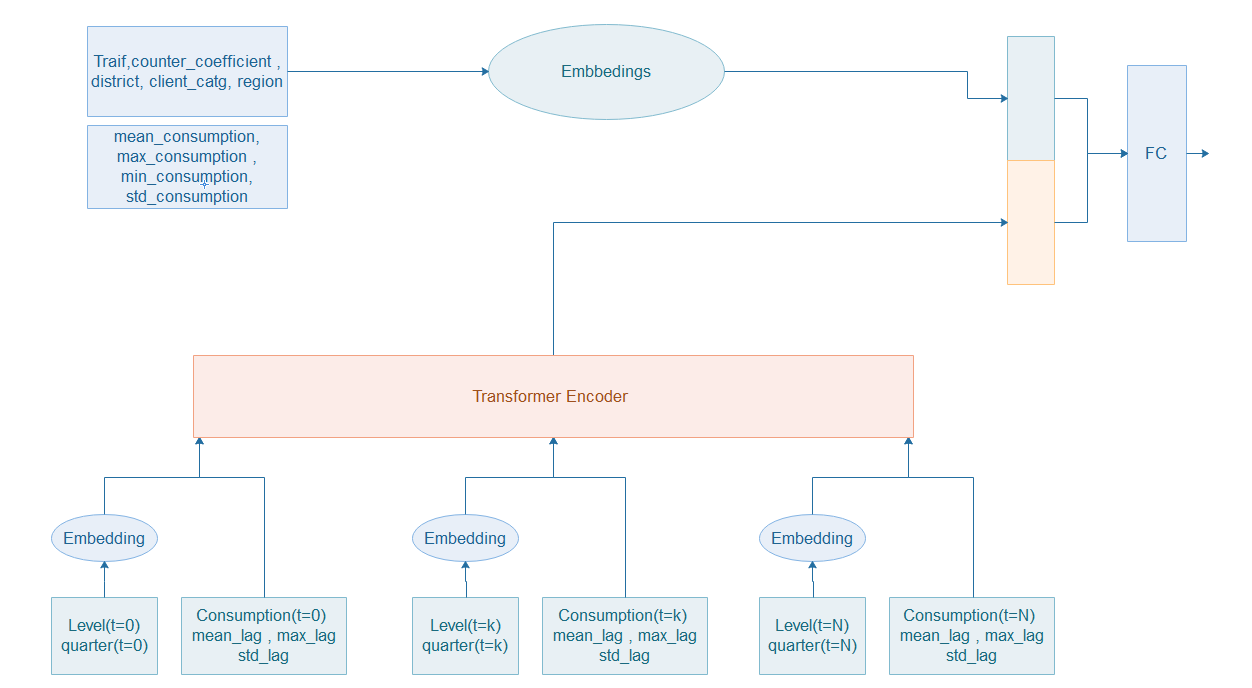

In [0]:
def Encoder_model(tgt_vocab, N=8, 
               d_model=256, d_ff=2048, h=8, dropout=0.15):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = Consupmtion_encoder(Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(Input_Layer(d_model), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [0]:
class steg_Transformer_model(nn.Module) : 
  
  def __init__(self, encoder , emb_size) : 
    
    super(steg_Transformer_model,self).__init__() 
    self.Encoder = encoder 

    outputs_cat = nn.ModuleList() # define the Embedding layer
    for inp , emb  in emb_size :
        embedding_layer = nn.Embedding(inp+2,emb)
        outputs_cat.append(embedding_layer)
    self.outputs_cat = outputs_cat 

    n_emb = sum([e[1] for e in emb_size])


    self.fc = nn.Sequential(  
                              nn.Linear( n_emb + 256 + len(num_colmuns)  ,2048),
                              nn.BatchNorm1d(2048),
                              nn.Dropout(0.3),
                              nn.PReLU(),
                              nn.Linear(2048,1024),
                              nn.BatchNorm1d(1024),
                              nn.Dropout(0.1),
                              nn.PReLU(),
                              nn.Linear(1024,512),
                              nn.BatchNorm1d(512),
                              nn.Dropout(0.05),
                              nn.PReLU(),
                              nn.Linear(512,1)
    )
    
  def forward(self,data) : 
   
      enc_output = self.Encoder(data,data['mask'].to(device,dtype=torch.long))
      
      
      
      
      outputs_emb = [] 
      for i in range(len(fix_columns)) : 
          inputs = data[fix_columns[i]].to(device,dtype=torch.long) 
          out = self.outputs_cat[i](inputs)
          outputs_emb.append(out.squeeze(1)) 
      x_cat = torch.cat(outputs_emb,dim= 1)
      x_num =  data["num"].to(device,dtype=torch.float) 
      x_all = torch.cat([x_cat,enc_output,x_num],dim=1)

      x_out = torch.sigmoid(self.fc(x_all)).to(device,dtype=torch.float) 

      return x_out

## Training the Transforemr model 

## unbalanced Data

In [0]:
#config 
NNBATCHSIZE = 64
EPOCHS = 2
LR = 0.0001
device = torch.device('cuda')

In [0]:
encoder  = Encoder_model(256)
model    = steg_Transformer_model(encoder,entity_dim)
model    = model.to(device)
resualts = run(model , validation = 'train_test_split' , mode='unbalanced' , Model_type = 'Transformer' , patience = 2 )


In [0]:
conf_matrix(test['Fraud_'+'unbalanced'+'_'+'Transformer'+'_'+'train_test_split'].values,test['Fraud'].values)

## upsampling

In [0]:
#config 
NNBATCHSIZE = 64
EPOCHS = 3
LR = 0.0001
device = torch.device('cuda')

In [0]:
encoder  = Encoder_model(256)
model    = steg_Transformer_model(encoder,entity_dim)
model    = model.to(device)
resualts = run(model , validation = 'train_test_split' , mode='upsampling' , Model_type = 'Transformer' , patience = 2 )


In [0]:
conf_matrix(test['Fraud_'+'upsampling'+'_'+'Transformer'+'_'+'train_test_split'].values,test['Fraud'].values)

In [0]:
print(classification_report(test['Fraud'].values , (test['Fraud_'+'upsampling'+'_'+'Transformer'+'_'+'train_test_split'].values >0.2).astype(int)))


## Downsampling 

In [0]:
#config 
NNBATCHSIZE = 64
EPOCHS = 100
LR = 0.0001
device = torch.device('cuda')

In [0]:
encoder  = Encoder_model(256)
model    = steg_Transformer_model(encoder,entity_dim)
model    = model.to(device)
resualts = run(model , validation = 'train_test_split' , mode='downsampling' , Model_type = 'Transformer' , patience = 5 )


In [0]:
conf_matrix(test['Fraud_'+'downsampling'+'_'+'Transformer'+'_'+'train_test_split'].values,test['Fraud'].values)

In [0]:
print(classification_report(test['Fraud'].values , (test['Fraud_'+'downsampling'+'_'+'Transformer'+'_'+'train_test_split'].values >0.2).astype(int)))


## 5-Folds 

In [0]:
NNBATCHSIZE = 128 
EPOCHS = 16
LR = 1e-3
device = torch.device('cuda')

In [0]:
for fold in range(5) : 
  encoder  = Encoder_model(256)
  model = steg_Transformer_model(encoder,entity_dim)
  model = model.to(device)
  run(model , validation = fold , mode='downsampling' , Model_type = 'Transformer' ,patience = 10 )

In [0]:
f = ['Fraud_downsampling_Transformer_'+str(i) for i in range(5)]
test['5_folds_Transformer'] = test[f].mean(axis=1)

In [0]:
conf_matrix(test['5_folds_Transformer'].values,test['Fraud'].values)

In [0]:
print(classification_report(test['Fraud'].values , (test['5_folds_Transformer'].values >0.2).astype(int)))

# Summary  of the results

In [0]:
plt.figure(figsize=(16,8))
plt.title('ROC Curve ', fontsize=18)

x, y, th = roc_curve(test['Fraud'], test['Fraud_upsampling_Transformer_train_test_split'])
plt.plot(x, y, label='Transformer upsampling auc : {:.4f} '.format(roc_auc_score(test['Fraud'], test['Fraud_upsampling_Transformer_train_test_split'])))

x, y, th = roc_curve(test['Fraud'], test['Fraud_downsampling_Transformer_train_test_split'])
plt.plot(x, y, label='Transformer downsampling auc: {:.4f}'.format(roc_auc_score(test['Fraud'], test['Fraud_downsampling_Transformer_train_test_split'])))

x, y, th = roc_curve(test['Fraud'], test['Fraud_unbalanced_Transformer_train_test_split'])
plt.plot(x, y, label='Transformer unbalanced auc : {:.4f}'.format(roc_auc_score(test['Fraud'], test['Fraud_unbalanced_Transformer_train_test_split'])))

x, y, th = roc_curve(test['Fraud'], test['5_folds_Transformer'])
plt.plot(x, y, label='Transformer 5 folds auc : {:.4f}'.format(roc_auc_score(test['Fraud'], test['5_folds_Transformer'])))

x, y, th = roc_curve(test['Fraud'], test['Fraud_upsampling_GRU_train_test_split'])
plt.plot(x, y, label='LSTM model upsampling auc : {:.4f} '.format(roc_auc_score(test['Fraud'], test['Fraud_upsampling_GRU_train_test_split'])))

x, y, th = roc_curve(test['Fraud'], test['Fraud_downsampling_GRU_train_test_split'])
plt.plot(x, y, label='LSTM model downsampling auc: {:.4f}'.format(roc_auc_score(test['Fraud'], test['Fraud_downsampling_GRU_train_test_split'])))

x, y, th = roc_curve(test['Fraud'], test['Fraud_unbalanced_GRU_train_test_split'])
plt.plot(x, y, label='LSTM model unbalanced auc : {:.4f}'.format(roc_auc_score(test['Fraud'], test['Fraud_unbalanced_GRU_train_test_split'])))

x, y, th = roc_curve(test['Fraud'], test['5_folds_GRU'])
plt.plot(x, y, label='LSTM model 5 folds auc : {:.4f}'.format(roc_auc_score(test['Fraud'], test['5_folds_GRU'])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)

plt.legend()
plt.show()